In [1]:
%cd ..

C:\Users\efurst1\PycharmProjects\LIDC_GDRO


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import data_util
import models
import torch
import loss
import train
import pandas as pd
import numpy as np

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

training_fraction = 0.8
batch_size = 160
proportional = True

is_gdro = True

hparams = {"groupdro_eta": 0.05, "mix_eta": 0.05}

In [5]:
# code to get max slice data from the all slices set

# all_slices = pd.read_csv('data/LIDC_20130817_AllFeatures2D_AllSlices_MattEdited.csv')
# max_slices = []

# nodule_radiologist_pairings = set(zip(all_slices["RadiologistID"], all_slices["noduleID"]))

# for radiologist_id, nodule_id in nodule_radiologist_pairings:
#     nodule_data = all_slices.loc[(all_slices["RadiologistID"] == radiologist_id) & (all_slices["noduleID"] == nodule_id), :]
    
#     max_slice = nodule_data.iloc[np.argmax(nodule_data["Area"]), :]
#     max_slices.append(max_slice)

# max_slice_df = pd.DataFrame(max_slices).sort_values(["noduleID", "RadiologistID"], axis=0).reset_index().drop(columns="index")
# max_slice_df

# Load and process data

In [11]:
df = data_util.preprocess_data(*data_util.load_data())
df

,noduleID,RadiologistID,Area,ConvexArea,Perimeter,ConvexPerimeter,EquivDiameter,MajorAxisLength,MinorAxisLength,Elongation,...,CNN_29,CNN_30,CNN_31,CNN_32,CNN_33,CNN_34,CNN_35,CNN_36,Malignancy,subtype
0,1,1,3.257792,3.328896,3.072804,2.793317,2.747487,2.396152,3.062397,-0.526848,...,-0.816555,-1.039873,0.713985,2.629349,-1.047577,0.377992,-0.264932,0.471167,1,marked_malignant
1,1,2,3.020470,3.144987,2.851889,2.678034,2.613058,2.283856,2.871833,-0.473642,...,-0.816555,-1.039873,0.713985,2.629349,-1.047577,0.377992,-0.264932,0.471167,1,marked_malignant
2,1,3,3.024237,3.119175,3.008903,2.697942,2.615224,2.148540,3.114954,-0.833560,...,-0.816555,-1.039873,0.713985,2.629349,-1.047577,0.377992,-0.264932,0.471167,1,marked_malignant
3,1,4,2.997868,3.064325,2.761518,2.746332,2.600044,2.437884,2.776038,-0.207783,...,-0.816555,-1.039873,0.713985,2.629349,-1.047577,0.377992,-0.264932,0.471167,1,marked_malignant
4,2,3,2.425283,2.109289,1.682746,1.982555,2.256623,2.041335,2.114829,0.056552,...,-0.724509,-0.781337,0.746117,-0.681622,-0.968940,0.966860,0.342148,0.762909,1,unmarked_malignant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3799,2689,1,-0.701332,-0.681609,-0.857740,-0.915260,-0.940950,-0.881056,-0.941862,0.021523,...,1.073132,1.164786,-1.054460,-0.324535,1.219170,-1.150920,0.060470,-1.017087,0,unmarked_benign
3800,2689,4,-0.637293,-0.623533,-0.712826,-0.770894,-0.775637,-0.820985,-0.689779,-0.790996,...,1.073132,1.164786,-1.054460,-0.324535,1.219170,-1.150920,0.060470,-1.017087,0,unmarked_benign
3802,2690,2,0.455139,0.386353,0.593479,0.736644,0.749119,0.901607,0.479511,1.001929,...,-1.366859,-1.123549,1.471881,-0.830906,-1.220246,1.520828,1.162344,1.612232,1,marked_malignant
3803,2690,3,0.085972,0.044347,0.243625,0.341964,0.354966,0.282671,0.394435,-0.217075,...,-1.366859,-1.123549,1.471881,-0.830906,-1.220246,1.520828,1.162344,1.612232,0,unmarked_benign


In [12]:
# get train/test flags
train_test = pd.read_csv("data/lidc_train_test_radiologist.csv")

# create train/test dataframes
training_df = df[df.index.isin(train_test[train_test["dataset"] == "train"].index.values)]
test_df = df[df.index.isin(train_test[train_test["dataset"] == "test"].index.values)]

# use noduleIDs as index, it makes things easier
# subtype_df.index = subtype_df["noduleID"].values


# Test convergence of combinations of ERM and GDRO

In [14]:
N = 10
epochs = 30
subtypes = ["Overall", "Unspiculated benign", "Spiculated benign", "Spiculated malignant", "Unspiculated malignant"]

# test_algorithms = ["ERM", "GDRO", "Sharp", "Smooth", "ReverseSmooth", "Dynamic", "ExtraERM", "ExtraGDRO", "Halfway"]
# test_algorithms = ["Mix" + str(t) for t in [0.4, 0.5, 0.6, 0.7, 0.8]]
test_algorithms = ["ERM", "GDRO"]# , "GDRO", *["Dynamic" + str(eta) for eta in [0, 0.01, 0.05, 0.1, 0.5]]]

results = {algorithm: np.zeros(N * epochs * len(subtypes)) for algorithm in test_algorithms}
for algorithm in test_algorithms:

    print("Running test: " + algorithm)

    # create the training and testing dataloaders
#     if algorithm == "ERM":
#         train_dataloader = data_util.create_dataloader(training_df, batch_size)
#     else:
#         train_dataloader = data_util.create_subtyped_dataloader(training_df, subtype_df, batch_size, proportional)
#     test_dataloader = data_util.create_subtyped_dataloader(test_df, subtype_df, batch_size, proportional)
    
    train_dataloader = data_util.create_dataloader(training_df, batch_size)
    test_dataloader = data_util.create_dataloader(test_df, batch_size)

    for n in range(N):

        print(f"Trial {n + 1}/{N}")

        # create and train model
        model = models.NeuralNetwork(100, 32, 32, 2)
        model.to(device)

        if (algorithm == "ERM"):
            loss_fn = loss.ERMLoss(model, torch.nn.CrossEntropyLoss(), hparams, subclassed=True)
        elif (algorithm == "GDRO"):
            loss_fn = loss.GDROLossAlt(model, torch.nn.CrossEntropyLoss(), hparams["groupdro_eta"], 4, normalize_loss=False)
        elif (algorithm.startswith("GDRO")):
            loss_fn = loss.GDROLossAlt(model, torch.nn.CrossEntropyLoss(), float(algorithm[len("GDRO"):]), 4, normalize_loss=True)
        elif (algorithm == "Dynamic"):
            loss_fn = loss.DynamicERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams["groupdro_eta"], hparams["mix_eta"], 4, normalize_loss=True, subclassed=True)
        elif (algorithm.startswith("Dynamic")):
            loss_fn = loss.DynamicERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams["groupdro_eta"], float(algorithm[len("Dynamic"):]), 4, normalize_loss=True, subclassed=True)
        else:
            loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams, 4, normalize_loss=True, subclassed=True)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)

        for epoch in range(epochs):
            if algorithm == "Sharp":
                loss_fn.t = epoch / epochs < 0.5  # sharp boundary
            elif algorithm == "Smooth":
                loss_fn.t = 1 - (epoch / (epochs - 1))  # linear interpolation
            elif algorithm == "ReverseSmooth":
                loss_fn.t = epoch / (epochs - 1)  # reverse linear interpolation
            elif algorithm == "ExtraERM":
                loss_fn.t = 2
            elif algorithm == "ExtraGDRO":
                loss_fn.t = -1
            elif algorithm == "Halfway":
                loss_fn.t = 0.5
            elif algorithm.startswith("Mix"):
                loss_fn.t = float(algorithm[3:])  # ex. algorithm == "Mix0.5" => t = 0.5

            train.train(train_dataloader, model, loss_fn, optimizer)
            sensitivities = train.test(test_dataloader, model)

            for i in range(len(subtypes)):
                results[algorithm][n * epochs * len(subtypes) + epoch * len(subtypes) + i] = sensitivities[i]

results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

print("Test complete")

Running test: ERM
Trial 1/10
Trial 2/10
Trial 3/10
Trial 4/10
Trial 5/10
Trial 6/10
Trial 7/10
Trial 8/10
Trial 9/10
Trial 10/10
Running test: GDRO
Trial 1/10
Trial 2/10
Trial 3/10
Trial 4/10
Trial 5/10
Trial 6/10
Trial 7/10
Trial 8/10
Trial 9/10
Trial 10/10
Test complete


In [15]:
trial_means = results_df.unstack().unstack().mean().unstack(level=0).unstack(level=1).stack()
trial_means

ERM      GDRO
subtype                epoch                    
Overall                0      0.867656  0.879062
                       1      0.886094  0.892969
                       2      0.884844  0.891875
                       3      0.891406  0.881094
                       4      0.895000  0.890625
...                                ...       ...
Unspiculated malignant 25     0.844474  0.897703
                       26     0.864843  0.896783
                       27     0.859208  0.916711
                       28     0.877505  0.881051
                       29     0.878575  0.900696

[150 rows x 2 columns]

In [21]:
worst_group = trial_means.unstack(level=1).min().unstack(level=0)
worst_group.index = pd.MultiIndex.from_product([["Worst"], worst_group.index], names=["subtype", "epoch"])
worst_concat = pd.concat([trial_means.unstack(level=1).stack(), worst_group])
worst_concat

ERM      GDRO
subtype epoch                    
Overall 0      0.867656  0.879062
        1      0.886094  0.892969
        2      0.884844  0.891875
        3      0.891406  0.881094
        4      0.895000  0.890625
...                 ...       ...
Worst   25     0.672416  0.678534
        26     0.726748  0.717718
        27     0.674853  0.673182
        28     0.675869  0.678062
        29     0.701559  0.649735

[180 rows x 2 columns]

In [ ]:
"""
Test parameters

input: 64 engineered features extracted from lidc max-slice images

model layer sizes = (64, 32, 32, 2)
groupdro_eta = 0.1
lr = 0.001
weight_decay = 0.005

batch_size = 40
proportional = True
epochs = 40
N = 120

"""

In [29]:
worst_concat = pd.read_csv('test_results/dynamic_mix_eta_sweep.csv')
worst_concat.index = pd.MultiIndex.from_product([subtypes + ["Worst"], range(epochs)])
worst_concat.drop(columns=["subtype", "epoch"], inplace=True)

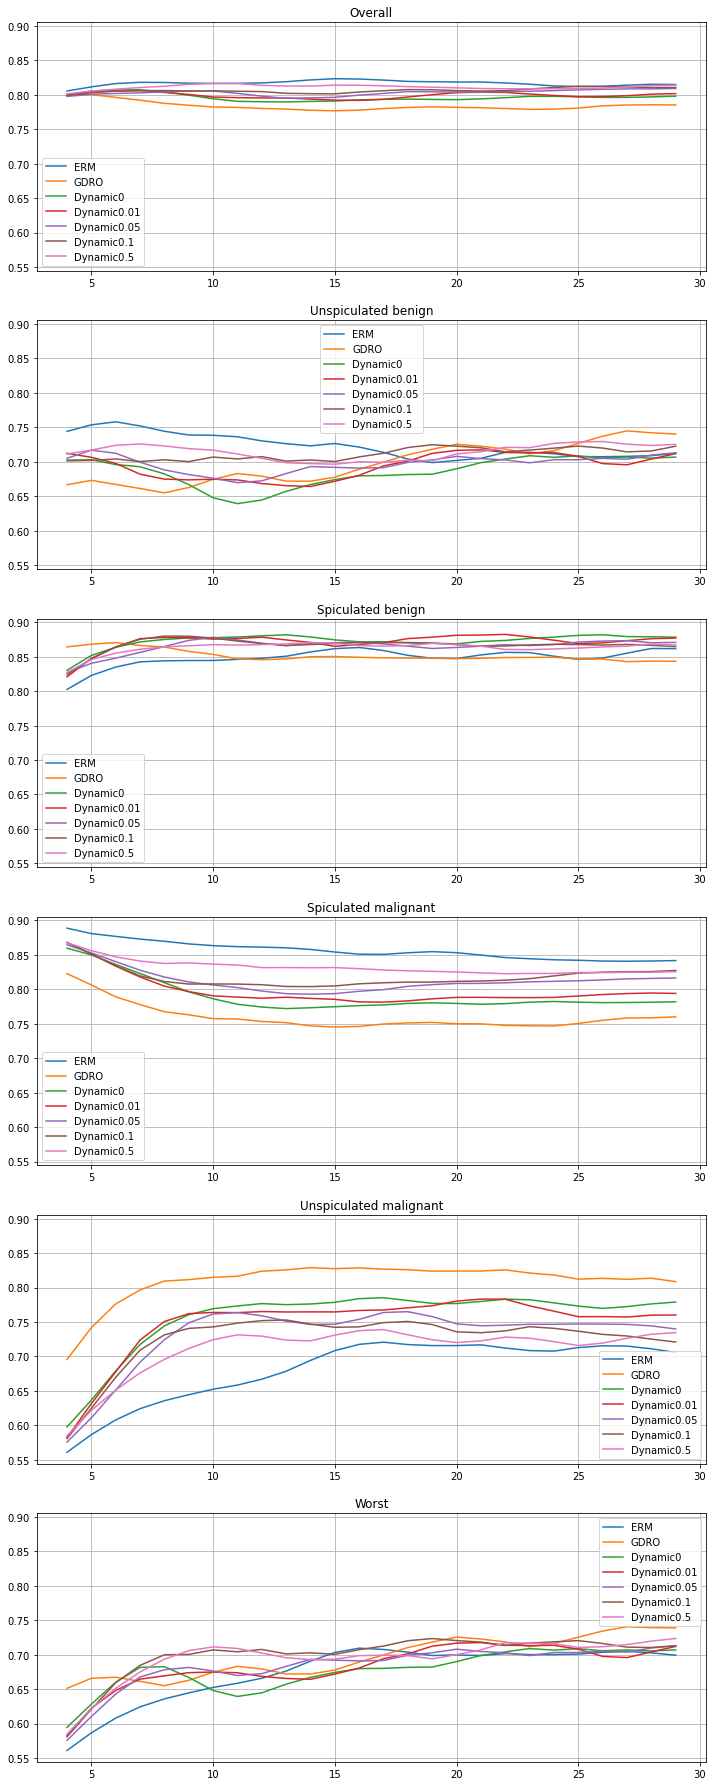

In [30]:
import matplotlib.pyplot as plt

rolling_window = 3

rolling_data = worst_concat.unstack(level=0).rolling(rolling_window).mean().unstack().unstack(level=0)

plots = [*subtypes, "Worst"]

hide = []

f, a = plt.subplots(len(plots),1, sharey=True)
# plot subtypes sensitivity
for i in range(len(plots)):
    rolling_data.drop(columns=hide).rolling(rolling_window).mean().xs(plots[i]).plot(kind='line',title=plots[i],ax=a[i],figsize=(12,32),grid=True)

In [ ]:
worst_concat.to_csv('test_results/dynamic_mix_eta_sweep.csv')

# GDRO Demonstration

In [ ]:
subtypes = ["Overall", "Unspiculated benign", "Spiculated benign", "Spiculated malignant", "Unspiculated malignant"]  # no overall needed

epochs = 100
N = 1

q_data = {}

for n in range(N):

    q_data[f'Trial_{n}'] = []
    
    model = models.NeuralNetwork(64, 32, 32, 2)
    model.to(device)

    loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams, len(subtypes) - 1, normalize_loss=True, subclassed=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)

    loss_fn.t = 0.5

    q_data[f'Trial_{n}'].extend([1 / (len(subtypes) - 1) for i in range(len(subtypes) - 1)])
    for epoch in range(epochs):
        train.train(train_dataloader, model, loss_fn, optimizer)
        q_data[f'Trial_{n}'].extend(loss_fn.gdro.q.tolist())

In [ ]:
q_df = pd.DataFrame(q_data, index=pd.MultiIndex.from_product([range(epochs + 1), subtypes[1:]], names=['epoch', 'subtype'])).mean(axis=1).unstack()
# columns get rearranged into alphabetical order, this swaps them back
q_df = q_df[subtypes[1:]]

In [ ]:
q_df.plot(xlabel="epoch", ylabel="q", title=f"Values of q over time (eta={hparams['groupdro_eta']}, Pure GDRO)")

# Old data

In [ ]:
# data for test_algorithms = ["ERM", "GDRO", "Sharp", "Smooth", "ReverseSmooth", "Adaptive", "ExtraERM", "ExtraGDRO", "Halfway"]
# N = 50, epochs = 20
all_data

In [ ]:
# old results with flawed malignancy labels + CNN subtypes
data_clean0

# Combining CNN features and engineered features

In [ ]:
cnn_df = pd.read_csv('data/cnn_features.csv')
for c in range(2, len(cnn_df.columns)):
    cnn_df.columns.values[c] = f'CNN_{cnn_df.columns.values[c]}'

eng_df = pd.read_csv('data/LIDC_20130817_AllFeatures2D_MaxSlice_MattEdited.csv')

In [ ]:
cnn_df = cnn_df[cnn_df['nodule_id'].isin(np.intersect1d(cnn_df['nodule_id'].values, eng_df['noduleID'].values))]
eng_df = eng_df[eng_df['noduleID'].isin(np.intersect1d(cnn_df['nodule_id'].values, eng_df['noduleID'].values))]

In [ ]:
concat_df = eng_df.copy()

In [ ]:
cnn_df.index = cnn_df['nodule_id']
for i in concat_df.index:
    for col in cnn_df.columns[2:]:
        concat_df.at[i, col] = cnn_df.at[concat_df.at[i, 'noduleID'], col]

In [ ]:
concat_df.drop(columns='Unnamed: 0').to_csv('data/AllFeatures2D_MaxSlice_with_CNN.csv', index=False)